In [78]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as ss
from dask_searchcv import RandomizedSearchCV as dask_RCV
from dask.distributed import Client
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.preprocessing import StandardScaler, normalize
import matplotlib.pyplot as plt
from scipy import stats as ss
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import roc_auc_score
import seaborn as sns


In [75]:
# creating dask parallel backend:
client = Client()
client.scheduler_info

<bound method Client.scheduler_info of <Client: scheduler='tcp://127.0.0.1:59554' processes=4 cores=4>>

In [2]:
df = pd.read_csv('train.csv')
columns = df.columns

In [3]:
df.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,267008.526389,2748.649934,155.834524,16.556746,228.376521,51.311706,1717.977712,213.028836,218.865741,134.477116,...,0.043849,0.040939,0.001190,0.006812,0.000926,0.002116,0.049206,0.041931,0.030159,4.000000
std,179261.722330,419.009589,109.745372,8.534602,209.196381,61.520488,1330.263450,30.638406,22.797288,46.070054,...,0.204766,0.198156,0.034484,0.082257,0.030416,0.045957,0.216306,0.200439,0.171030,2.000066
min,5.000000,1877.000000,0.000000,0.000000,0.000000,-135.000000,0.000000,52.000000,99.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,103705.000000,2373.000000,65.000000,10.000000,67.000000,5.000000,760.000000,197.000000,207.000000,106.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,276034.500000,2754.000000,125.000000,15.000000,180.000000,32.000000,1315.000000,220.000000,223.000000,138.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,398150.250000,3109.000000,257.000000,22.000000,330.000000,80.000000,2292.000000,236.000000,235.000000,166.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,581005.000000,3850.000000,360.000000,50.000000,1376.000000,570.000000,6803.000000,254.000000,254.000000,251.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [4]:
df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,242642,2881,130,22,210,54,1020,250,221,88,...,0,0,0,0,0,0,0,0,0,1
1,309891,3005,351,14,242,-16,1371,194,215,159,...,0,0,0,0,0,0,0,0,0,1
2,287847,3226,63,14,618,2,1092,232,210,107,...,0,0,0,0,0,0,0,0,0,1
3,516307,3298,317,8,661,60,752,198,233,174,...,0,0,0,0,0,0,0,0,0,1
4,124860,3080,35,6,175,26,3705,219,227,144,...,0,0,0,0,0,0,0,0,0,1


### Data Exploration

In [80]:
# Plotting Explained variance
def plot_explained_var(dfX):
    std=StandardScaler()
    dfX = std.fit_transform(dfX)
    # Covariance matrix
    cov_mat = np.cov(dfX.T)
    #eigen values
    eig_vals,eig_vecs = np.linalg.eig(cov_mat)

    tot = sum(eig_vals)
    var_exp = [(i/tot) for i in sorted(eig_vals, reverse = True)]
    cum_var_exp = np.cumsum(var_exp)
    plt.bar(range(1,dfX.shape[1]+1),var_exp,alpha=0.5, align='center',label="Individual explained variance")
    plt.step(range(1,dfX.shape[1]+1),cum_var_exp,where='mid', label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal Components')
    plt.legend(loc='best')
    print('cumulative explained variance of first 5 :', cum_var_exp[:5])
    
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

cumulative explained variance of first 5 : [ 0.08075539  0.13754855  0.18238715  0.22025472  0.25039204]


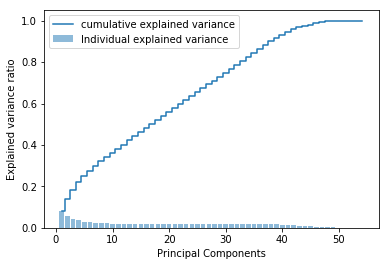

In [6]:
plot_explained_var(df.ix[:,1:-1])

#### Feature Engineering

In [76]:
# Mapping Climatic and geologic zones:

class feature_engg(object):
    
    def fit(self,df):
        self.df = df
        dictionary = {1: [2,7],2: [2,7],3: [2,7],4: [2,7],5: [2,7],6: [2,7],7: [3,5],8: [3,5],9: [4,2],10: [4,7],11: [4,7],12: [4,7],
        13: [4,7],14: [5,1],15: [5,1],16: [6,1],17: [6,1],18: [6,7],19: [7,1],
        20: [7,1],21: [7,1],22: [7,2],23: [7,2],24: [7,7],25: [7,7],26: [7,7],27: [7,7],28:[7,7],29:[7,7],
        30: [7,7],31:[7,7],32:[7,7],33:[7,7],34:[7,7],35:[8,7],36:[8,7],37:[8,7],38:[8,7],39:[8,7],40:[8,7]}
        columns = self.df.columns
        self.df['climatic_zone'] = 0
        self.df['geologic_zone'] = 0
        self.df['Soil'] = 0
        for n in range(self.df.shape[0]):
            for i in range(15,55):
                if self.df[columns[i]][n]==1:
                    self.df['Soil'][n] =  i-14
                    self.df['climatic_zone'][n] = dictionary[i-14][0]
                    self.df['geologic_zone'][n] = dictionary[i-14][1]

                    break
                else:
                    pass
        dfX = self.df.drop(columns[15:55],axis=1)
        dfX.drop(['Id'],axis=1,inplace=True)
        return dfX
    

For categorical variable 'Soil', encoding using Bayes Empirical formulae tried but it didnot improve any results, hence it was not used.
The encoding is done as follows:
>The categorical variable X is mapped to a scalar value $S_i$ representing an estimate of the probability of each class $Y=1$ for each unique categorical variable $X = Xi$ 
> 
> Basic principle $\to$  $ S_i \cong P(Y | X=Xi )$
> $$ S_i = \lambda (n_i) \frac {( n_{iY}  )}{n_i} + (1- \lambda (n_i)) \frac {n_Y}{n_{TR}}$$ 
>
> *Reference : Daniele Micci-Barreca. 2001. A preprocessing scheme for high-cardinality categorical attributes in classification and prediction problems. SIGKDD Explor. Newsl. 3, 1 (July 2001), 27-32*

cumulative explained variance of first 5 : [ 0.27555304  0.43351396  0.55574499  0.64760795  0.7213635 ]


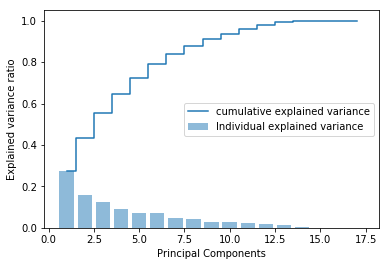

In [58]:
f_engg = feature_engg()
dfX = f_engg.fit(df)
Y = dfX['Cover_Type']
dfX = dfX.drop(['Cover_Type'],axis=1)
cols = dfX.columns           
plot_explained_var(dfX)

Comparing the above graph with the previous graph on explained variance, it is clear that the new features have improved class separability.

In [21]:
# Scaling Data
std = StandardScaler()
dfX = std.fit_transform(dfX)
dfX = pd.DataFrame(dfX, columns= cols)

Visualizing covariance within the feature space

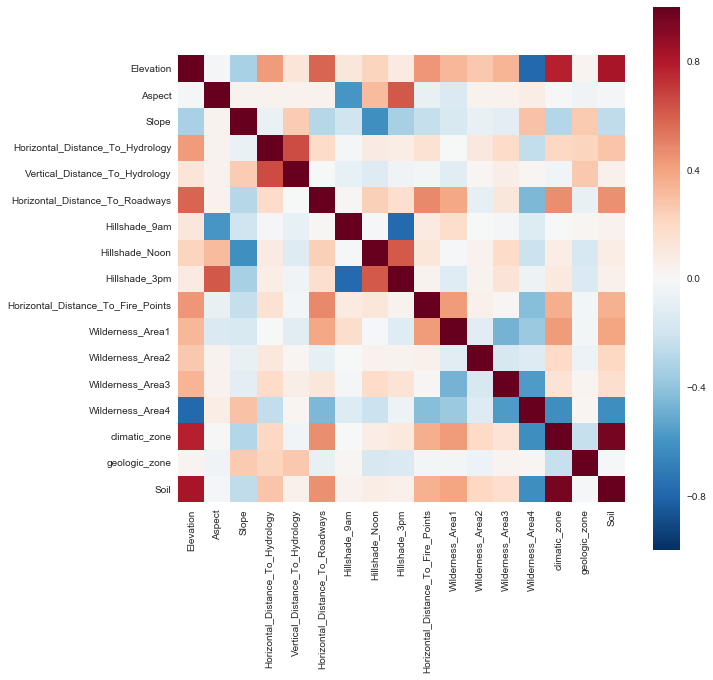

In [79]:
plot_corr(dfX)

Looking at density plots of each variable

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000215526C0C50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002155468DFD0>]], dtype=object)

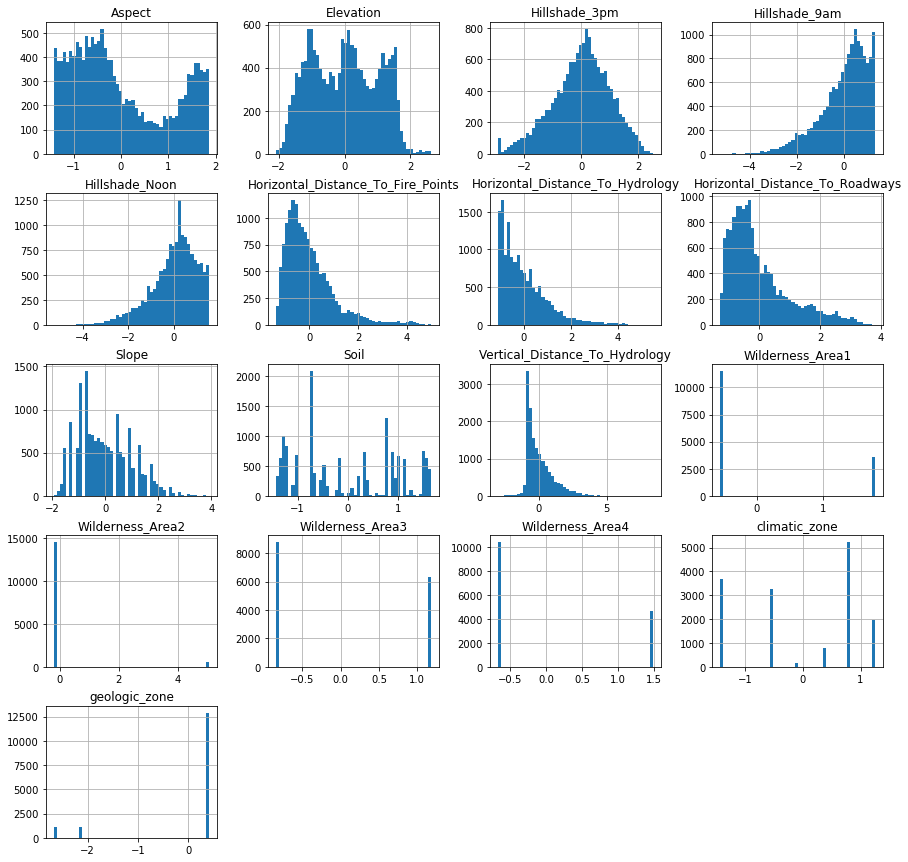

In [169]:
dfX.hist(figsize=(15,15),bins=50 )

Based on density plots, features with heave tail distributions can be transformed with 'log' value to improve the distribution but in this case, transformation of data did not have any affect on the prediction, the idea was abandoned.

#### Split datset

In [22]:
#Splitting into train and  test (by default, the class balance is nearly maintained)
X_train,X_test,y_train,y_test = train_test_split(dfX,Y,test_size = 0.3)


The data is split with nearly equal class distribution

(array([ 1537.,  1518.,     0.,  1504.,     0.,  1501.,  1519.,     0.,
         1503.,  1502.]),
 array([ 1. ,  1.6,  2.2,  2.8,  3.4,  4. ,  4.6,  5.2,  5.8,  6.4,  7. ]),
 <a list of 10 Patch objects>)

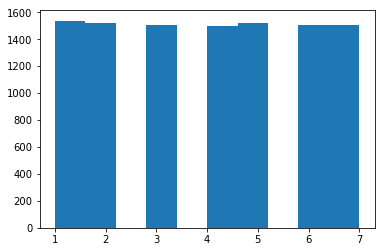

In [171]:
plt.hist(y_train)

### Benchmark Models

### LDA 

LDA transformation usually improves class separability

In [172]:
lda =LDA(n_components =6)
X_train_lda = lda.fit_transform(X_train,y_train)
X_test_lda = lda.transform(X_test)
y_pred = lda.predict(X_test)
print ('Accuracy: ', metrics.accuracy_score(y_pred=y_pred,y_true=y_test))
metrics.confusion_matrix(y_test,y_pred)

Accuracy:  0.649029982363


C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


array([[332, 107,   0,   0,  47,   3, 134],
       [128, 280,  13,   2, 170,  14,  35],
       [  0,   2, 264, 147,  30, 213,   0],
       [  0,   0,  30, 601,   0,  28,   0],
       [  1,  74,  30,   0, 525,  11,   0],
       [  0,   4, 117,  92,  79, 365,   0],
       [ 78,   0,   0,   0,   3,   0, 577]])

#### GBC

In [71]:
# GBC
clf = GBC(n_estimators= 300,max_depth=6)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print ('Accuracy: ', metrics.accuracy_score(y_pred=y_pred,y_true=y_test))
metrics.confusion_matrix(y_test,y_pred)

Accuracy:  0.845679012346


array([[493, 106,   0,   0,  17,   1,  43],
       [130, 451,  14,   0,  54,  16,   6],
       [  0,   1, 520,  25,   6, 102,   0],
       [  0,   0,  16, 642,   0,  12,   0],
       [  2,  20,   9,   0, 628,   4,   0],
       [  1,   7,  61,   9,  10, 533,   0],
       [ 26,   0,   0,   0,   2,   0, 569]])

#### SVM

In [174]:
# SVM
clf = SVC(kernel='poly', C= 1000, gamma=0.1)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print ('Accuracy: ', metrics.accuracy_score(y_pred=y_pred,y_true=y_test))
metrics.confusion_matrix(y_test,y_pred)

Accuracy:  0.795194003527


array([[425, 141,   0,   0,  12,   2,  43],
       [138, 423,  10,   0,  50,  14,   7],
       [  1,  19, 471,  36,  13, 116,   0],
       [  0,   0,  27, 612,   0,  20,   0],
       [  8,  65,   6,   0, 560,   2,   0],
       [  4,  28,  84,  16,  13, 512,   0],
       [ 49,   5,   0,   0,   0,   0, 604]])

#### KNN

In [219]:
clf_knn = KNC(n_neighbors=5)
clf_knn.fit(X_train,y_train)
y_pred = clf_knn.predict(X_test)
print ('Accuracy: ', metrics.accuracy_score(y_pred=y_pred,y_true=y_test))
metrics.confusion_matrix(y_test,y_pred)

Accuracy:  0.762566137566


array([[397, 124,   1,   0,  41,   2,  58],
       [145, 354,  16,   0,  89,  22,  16],
       [  0,   9, 406,  69,  15, 157,   0],
       [  0,   0,  16, 631,   0,  12,   0],
       [ 14,  27,   8,   0, 583,   8,   1],
       [  3,  12, 105,  34,  30, 473,   0],
       [ 36,   7,   0,   0,   0,   0, 615]])

#### Multi Layer Neural Networks

In [179]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras import optimizers
from keras.utils.np_utils import to_categorical

In [180]:
Y_train = to_categorical(y_train)

In [181]:
Y_train.shape

(10584, 8)

In [204]:
N = X_train.shape[1]
H1 = 300
H2 = 150
K = Y_train.shape[1]
model = Sequential()
model.add(Dense(H1, input_dim=N))
model.add(Activation("relu"))
model.add(Dense(H2))
model.add(Activation("relu"))
model.add(Dense(K))
model.add(Activation("softmax"))
model.compile(optimizer = optimizers.SGD(lr=0.5),loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train.values,Y_train,epochs=65,batch_size=100)


Epoch 1/65
10584/10584 [==============================] - 0s - loss: 0.9808 - acc: 0.5929      
Epoch 2/65
10584/10584 [==============================] - 0s - loss: 0.7622 - acc: 0.6792     

In [206]:
y_pred = model.predict_classes(X_test.values)
print ('Accuracy: ', metrics.accuracy_score(y_pred=y_pred,y_true=y_test))
metrics.confusion_matrix(y_test,y_pred)

4000/4536 [=========================>....] - ETA: 0sAccuracy:  0.834215167549


array([[425, 127,   0,   0,  12,   0,  59],
       [107, 445,   6,   0,  48,  26,  10],
       [  1,   5, 438,  51,  12, 149,   0],
       [  0,   0,   7, 643,   0,   9,   0],
       [  5,  23,   2,   0, 600,  11,   0],
       [  0,   7,  32,  16,  12, 590,   0],
       [ 14,   1,   0,   0,   0,   0, 643]])

### Hyper Parameter Tuning

Based on initial benchmark tests, Gradient Boosting method is selected for further parameter tuning.

In [209]:
%%time
params= {
             'n_estimators' :scipy.stats.randint(100, 800), 
             'max_depth': range(1,17),
             'max_features' : scipy.stats.randint(1, 11)}
           
dgrid_search = dask_RCV(GBC(),params,cv=5)
dgrid_search.fit(X_train,y_train)
best_params =  dgrid_search.best_params_
print('best estimator: ', dgrid_search.best_estimator_)
print('best parameters:', best_params)
print('best score: ', dgrid_search.best_score_)  

best estimator:  GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=9, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=560, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)
best parameters: {'max_depth': 10, 'max_features': 9, 'n_estimators': 560}
best score:  0.854780801209
Wall time: 28min 41s


### TEST SET

In [9]:
df_test = pd.read_csv('test.csv')

In [10]:
df_test.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,290506.500000,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,...,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060
std,167723.861638,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,...,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791
min,1.000000,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,145253.750000,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,290506.500000,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,435759.250000,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,581012.000000,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df_test.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,0
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,0
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,0
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,0
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,0


#### Feature Transformation & Prediction

In [47]:
f_engg = feature_engg()
clf_final = GBC(max_depth=best_params[0], max_features=best_params[1], n_estimators=best_params[2])
dfX_test = f_engg.fit(dfX_test)
clf_final.fit(X_train,y_train)
y_pred = clf_final.predict(dfX_test)

TEST set prediction distribution:

(array([ 488139.,   13972.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,   78901.]),
 array([ 1. ,  1.6,  2.2,  2.8,  3.4,  4. ,  4.6,  5.2,  5.8,  6.4,  7. ]),
 <a list of 10 Patch objects>)

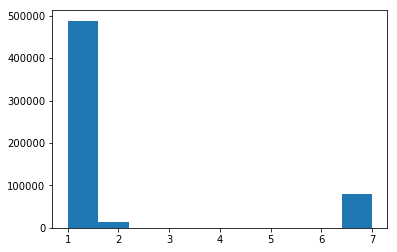

In [48]:
plt.hist(y_pred)